In [13]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb
import catboost
from sklearn.neural_network import MLPRegressor
from scipy.special import softmax

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [14]:
def load_data(y):
    path = '../data/'
    x_train_std = pd.read_pickle(path +'std_data/train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'std_data/test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'std_data/train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'std_data/test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'std_data/train/{}_x.pkl'.format(str(y))).columns
    
    with open(path +'nominate_movie_meta_data.json', 'r') as json_data:
        data = json.load(json_data)
    title = [dict["title"] for dict in data[str(y)]]

    return x_train_std, x_test_std, y_train, y_test, features, title

In [15]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [16]:
def train():
    
    # アンサンブルの重み  [w_lr, w_lda, w_sv, w_xgb, w_lgbm, w_cb, w_mlp]
    w = np.array([0.10583359, 0.03752913, 0.26870715, 0.09771777, 0.10549716, 0., 0.3847152 ])
    
    # confusion matrix
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all_lr = np.array([])
    probs_all_lda = np.array([])
    probs_all_sv = np.array([])
    probs_all_lgbm = np.array([])
    probs_all_xgb = np.array([])
    probs_all_cb = np.array([])
    probs_all_mlp = np.array([])
    
    probs_all = np.array([])
    y_true_all = np.array([])
    
    predict_rank = [0, 0, 0, 0, 0, 0] # 実際の受賞作品をモデルは何位と予想するかのカウント
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features, title = load_data(y)
        title[0] = '★' + title[0] #最優秀作品のタイトルに印をつける
        
        y_true_all = np.hstack((y_true_all, y_test))
       
        # logistic regression
        lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001,  random_state=0,) # ロジスティック回帰モデルのインスタンスを作成
        lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
        probs_lr = lr.predict_proba(x_test_std)[:,1]
        probs_all_lr = np.hstack((probs_all_lr, probs_lr))
        
        # LDA
        lda = LDA(solver="eigen", shrinkage=1).fit(x_train_std,  y_train)
        probs_lda = lda.predict_proba(x_test_std)[:,1]
        probs_all_lda = np.hstack((probs_all_lda, probs_lda))
        
        # svm
        sv = svm.SVR(kernel="sigmoid",
                                     degree=4,
                                     gamma=0.043502212815589775,
                                     coef0=0.20190829020616494,
                                     tol=0.0001,
                                     C=0.000245786293391316,
                                     epsilon=0.3056167642389302,
                                    verbose=False,)
        sv.fit(x_train_std, y_train)
        probs_sv = sv.predict(x_test_std)
        probs_all_sv = np.hstack((probs_all_sv, probs_sv))
        
        # xgb
        xgboost = xgb.XGBRegressor(silent= True, 
                                random_state=0,
                               max_depth=4,
                               learning_rate=0.12765177534095626,
                               n_estimators = 46,
                               gamma=0.060805284848630535,
                               reg_lambda=4.995675788308118,
                               reg_alpha=2.1912254426545754,
                               sub_sample=0.45297631180790854,
                               scale_pos_weight=1.1672978934986058)
        xgboost.fit(x_train_std, y_train)
        probs_xgb = xgboost.predict(x_test_std)
        probs_all_xgb = np.hstack((probs_all_xgb, probs_xgb))
        
        
        
        # lgbm
        lgbm = lgb.LGBMRegressor(
            random_state=0,
            verbosity=-1,
            bagging_seed=0,
            boost_from_average='true',
            metric='auc',
            bagging_freq=4,
            min_data_in_leaf=21,
            max_depth=13,
            learning_rate=0.08731913651405197,
            n_estimators=3394,
            subsample=0.7054763057027115,
            num_leaves=438,
            reg_lambda=0.9377125325944119,  
        )
        
        lgbm.fit(x_train_std, y_train)
        probs_lgbm = lgbm.predict(x_test_std)
        probs_all_lgbm = np.hstack((probs_all_lgbm, probs_lgbm))
        
        # catboost
        cb = catboost.CatBoostRegressor(
             random_state=0,
            iterations=258,
            depth=2,
            learning_rate=0.019083573879517587,
            random_strength=84,
            bagging_temperature=0.3233702745357832,
            od_type="Iter",
            od_wait=32, 
            logging_level='Silent')
        cb.fit(x_train_std, y_train)
        probs_cb = cb.predict(x_test_std)
        probs_all_cb = np.hstack((probs_all_cb, probs_cb))   
        
        # mlp
        mlp = MLPRegressor(hidden_layer_sizes=(32,),
                           activation='relu',
                           solver='adam',
                           alpha=4.76324733221396,
                           batch_size='auto',
                           learning_rate='constant', 
                           learning_rate_init=0.0012043271455668674, 
                           power_t=0.5,
                           max_iter=1000, 
                           shuffle=True,
                           random_state=0, 
                           tol=0.0001, 
                           verbose=False, 
                           warm_start=False, 
                           momentum=0.9,
                           nesterovs_momentum=True, 
                           early_stopping=False, 
                           validation_fraction=0.1, 
                           beta_1=0.022158342014810775, 
                           beta_2= 0.7802116425099002,
                           epsilon=1e-08,
                           )
        mlp.fit(x_train_std, y_train)
        probs_mlp = mlp.predict(x_test_std)
        probs_all_mlp = np.hstack((probs_all_mlp, probs_mlp))
        
        #アンサンブル
        all_models_probs = [probs_lr, probs_lda, probs_sv, probs_xgb, probs_lgbm, probs_cb, probs_mlp]
        # 各モデル結果の重み付き平均
        probs_weighted_average = np.array([0 for i in range(len(y_test))], dtype='float64')
        for probs, weight in zip(all_models_probs, w):
            probs_weighted_average += (probs * weight)
        probs_all = np.hstack((probs_all, probs_weighted_average))
        
        probs_weighted_average = softmax(probs_weighted_average)  # ソフトマックス関数で確率に
        sorted_answer = sorted(list(zip(title, probs_weighted_average)), key=lambda x: -x[1]) #(title, prob)のタプルのリストを順位でソート
        
        correct = "o" if np.max(probs_weighted_average) == probs_weighted_average[0] else "x"
        
        print(str(y) + " : " + correct)
        for rank, ans in enumerate(sorted_answer):
            title, prob = ans
            print(rank + 1, title, prob)

        predict_rank[np.where(np.argsort(-probs_weighted_average) == 0)[0][0]]  =  predict_rank[np.where(np.argsort(-probs_weighted_average) == 0)[0][0]] + 1
        
        
        print()
        
        # 混同行列
        y_pred = np.where((probs_weighted_average ==  max(probs_weighted_average)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    auc_lr = roc_auc_score(y_true_all, probs_all_lr)
    auc_lda = roc_auc_score(y_true_all, probs_all_lda)
    auc_sv = roc_auc_score(y_true_all, probs_all_sv)
    auc_xgb = roc_auc_score(y_true_all, probs_all_xgb)
    auc_lgbm = roc_auc_score(y_true_all, probs_all_lgbm)
    auc_cb = roc_auc_score(y_true_all, probs_all_cb)
    auc_mlp = roc_auc_score(y_true_all, probs_all_mlp)
    auc = roc_auc_score(y_true_all, probs_all)
    
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    for ind, rank in enumerate(predict_rank):
        if ind == 0:
            print("正解: {}".format(rank))
        else:
            print("{0}位と予想: {1}".format(ind + 1, rank))
    print()
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC LR: ",auc_lr)
    print("AUC LDA: ",auc_lda)
    print("AUC svm: ",auc_sv)
    print("AUC xgb: ",auc_xgb)
    print("AUC lgbm: ", auc_lgbm)
    print("AUC CB: ",auc_cb)
    print("AUC MLP: ",auc_mlp)
    print("AUC: ",auc)
    print()
    return 

1978 : o
1 ★幸福の黄色いハンカチ 0.21211494166789108
2 はなれ瞽女おりん 0.20271152657643707
3 青春の門 自立篇（1977） 0.19697570068352707
4 八甲田山 0.19500756927615112
5 竹山ひとり旅 0.19319026179599344

1979 : x
1 サード 0.2155259307874774
2 ★事件 0.21110047235878657
3 柳生一族の陰謀 0.1934567166820052
4 鬼畜 0.19315474264913854
5 愛の亡霊 0.18676213752259244

1980 : x
1 あゝ野麦峠 0.22055644394326254
2 ★復讐するは我にあり 0.20439027550102468
3 太陽を盗んだ男 0.20391847252231093
4 衝動殺人 息子よ 0.18558182100379342
5 もう頬づえはつかない 0.18555298702960846

1981 : x
1 遙かなる山の呼び声 0.20977925856859042
2 ★ツィゴイネルワイゼン 0.20185186194560692
3 動乱 0.19712352151077708
4 二百三高地 0.19660126750373136
5 父よ母よ! 0.19464409047129425

1982 : x
1 泥の河 0.21809022434070122
2 ええじゃないか 0.20574362715575112
3 ★駅/STATION 0.19972510377099267
4 遠雷 0.19806557521750065
5 日本の熱い日々 謀殺・下山事件 0.17837546951505404

1983 : o
1 ★蒲田行進曲 0.23386802947971347
2 未完の対局 0.19839352880344394
3 疑惑 0.19182559936663973
4 誘拐報道 0.1900104795918232
5 鬼龍院花子の生涯 0.18590236275837962

1984 : x
1 家族ゲーム 0.21055828164177962
2 戦場のメリークリスマス 0.2095

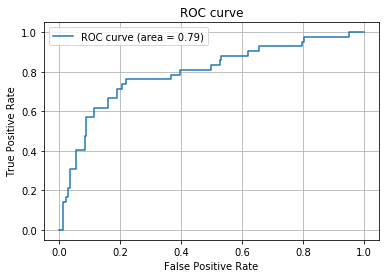

正解: 22
2位と予想: 10
3位と予想: 3
4位と予想: 4
5位と予想: 3
6位と予想: 0

confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LR:  0.7482389405466329
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC CB:  0.7561284868977177
AUC MLP:  0.777120315581854
AUC:  0.7948717948717948



In [17]:
train()